# Starsim - UC Berkeley EE122 Final Project

In order to better understand the performance considerations and requirements of LEO internet satellite constellations, we built a simulated model of the Starlink network, complete with real orbital data, ground stations, packet routing, and metrics generation. Specifically, we wanted to investigate how network performance (measured by packets dropped, downtime, and satellite utilization) changed with respect to the size of the LEO constellation (number of satellites). 
	
Our simulation consists of three main components. First, the network topology, which comprises the programmatic representations of Starlink satellites, ground stations, ground nodes (end users) and the geographic environment. Next, simulated traffic and routing, which are defined by the process of routing packets from one end user to ground stations or other end users (and how they are affected by link capacity / range and satellite movement). The final component was metrics generation; we decided to measure the number of packets dropped, downtime of packet transmission (how often ground nodes were unable to connect to the satellites), and the overall number of satellites utilized by the routing algorithm during the entire simulation. 


# Dependencies

In [ ]:
!pip install poliastro[jupyter]
!pip install httpx
!pip install sgp4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [ ]:
import io
import json
import xml.etree.ElementTree as ET

import httpx
from sgp4 import exporter, omm
from sgp4.api import Satrec

import numpy as np

from astropy.coordinates import CartesianRepresentation, CartesianDifferential

from poliastro.util import time_range

from warnings import warn

from astropy.coordinates import TEME, GCRS

from poliastro.ephem import Ephem
from poliastro.frames import Planes

from poliastro.bodies import Earth
from poliastro.plotting import OrbitPlotter3D

from astropy import units as u
from astropy.time import Time

# Earth focused modules, ISS example orbit and time span generator
from poliastro.earth import EarthSatellite
from poliastro.earth.plotting import GroundtrackPlotter
from poliastro.examples import iss

from uuid import uuid4
from tqdm import tqdm

import networkx as nx

## Utility functions for fetching NORAD/Celestrak orbital data / cartesian coordinates for satellites

In [ ]:
def _generate_url(catalog_number, international_designator, name):
    params = {
        "CATNR": catalog_number,
        "INTDES": international_designator,
        "NAME": name,
    }
    param_names = [
        param_name
        for param_name, param_value in params.items()
        if param_value is not None
    ]
    if len(param_names) != 1:
        raise ValueError(
            "Specify exactly one of catalog_number, international_designator, or name"
        )
    param_name = param_names[0]
    param_value = params[param_name]
    url = (
        "https://celestrak.org/NORAD/elements/gp.php?"
        f"{param_name}={param_value}"
        "&FORMAT=XML"
    )
    return url


def _segments_from_query(url):
    response = httpx.get(url)
    response.raise_for_status()

    if response.text == "No GP data found":
        raise ValueError(
            f"Query '{url}' did not return any results, try a different one"
        )
    tree = ET.parse(io.StringIO(response.text))
    root = tree.getroot()

    yield from omm.parse_xml(io.StringIO(response.text))


def load_gp_from_celestrak(
    *, catalog_number=None, international_designator=None, name=None
):
    """Load general perturbations orbital data from Celestrak.

    Returns
    -------
    Satrec
        Orbital data from specified object.

    Notes
    -----
    This uses the OMM XML format from Celestrak as described in [1]_.

    References
    ----------
    .. [1] Kelso, T.S. "A New Way to Obtain GP Data (aka TLEs)"
       https://celestrak.org/NORAD/documentation/gp-data-formats.php

    """
    # Assemble query, raise an error if malformed
    url = _generate_url(catalog_number, international_designator, name)

    # Make API call, raise an error if data is malformed
    for segment in _segments_from_query(url):
        # Initialize and return Satrec object
        sat = Satrec()
        omm.initialize(sat, segment)

        yield sat


def print_sat(sat, name):
    """Prints Satrec object in convenient form."""
    print(json.dumps(exporter.export_omm(sat, name), indent=2))

def ephem_from_gp(sat, times):
    errors, rs, vs = sat.sgp4_array(times.jd1, times.jd2)
    if not (errors == 0).all():
        warn(
            "Some objects could not be propagated, "
            "proceeding with the rest",
            stacklevel=2,
        )
        rs = rs[errors == 0]
        vs = vs[errors == 0]
        times = times[errors == 0]

    cart_teme = CartesianRepresentation(
        rs << u.km,
        xyz_axis=-1,
        differentials=CartesianDifferential(
            vs << (u.km / u.s),
            xyz_axis=-1,
        ),
    )
    cart_gcrs = (
        TEME(cart_teme, obstime=times)
        .transform_to(GCRS(obstime=times))
        .cartesian
    )

    return Ephem(cart_gcrs, times, plane=Planes.EARTH_EQUATOR), cart_gcrs

## Classes for Internet Satellite and Ground Node 

In [ ]:
class InternetSatellite:
    def __init__(self, name, orbital_data, cartesian_coords, ephem):
        self.uuid = uuid4()
        self.name = name
        self.ephem = orbital_data
        self.cartesian_coords = cartesian_coords  # KM
        self.ephem = ephem
        self.orbit_step = 0
        self.x = float(cartesian_coords[self.orbit_step].x / u.km)  # KM
        self.y = float(cartesian_coords[self.orbit_step].y / u.km)  # KM
        self.z = float(cartesian_coords[self.orbit_step].z / u.km)  # KM

    def __str__(self):
        return self.name

    def get_xyz(self):
      return np.array([self.x, self.y, self.z])

    def orbit_update(self):
      self.orbit_step = (self.orbit_step + 1) % len(self.cartesian_coords)
      self.x = float(self.cartesian_coords[self.orbit_step].x / u.km)  # KM
      self.y = float(self.cartesian_coords[self.orbit_step].y / u.km)  # KM
      self.z = float(self.cartesian_coords[self.orbit_step].z / u.km)  # KM


## Creating Starlink LEO Constellation

In [ ]:
# 100 satellites
STARLINK_SAT_NAMES = [
    "STARLINK-1007", "STARLINK-1008", "STARLINK-1009", "STARLINK-1010", "STARLINK-1011", 
    "STARLINK-1140", "STARLINK-1141", "STARLINK-1148", "STARLINK-1155", "STARLINK-1156", 
    "STARLINK-1310", "STARLINK-1319", "STARLINK-1305", "STARLINK-1304", "STARLINK-1302", 
    "STARLINK-1019", "STARLINK-1020", "STARLINK-1021", "STARLINK-1022", "STARLINK-1024", 
    "STARLINK-1181", "STARLINK-1185", "STARLINK-1183", "STARLINK-1147", "STARLINK-1193", 
    "STARLINK-1194", "STARLINK-1174", "STARLINK-1180", "STARLINK-1177", "STARLINK-1149", 
    "STARLINK-1256", "STARLINK-1291", "STARLINK-1284", "STARLINK-1263", "STARLINK-1272", 
    "STARLINK-1372", "STARLINK-1377", "STARLINK-1309", "STARLINK-1338", "STARLINK-1376", 
    "STARLINK-1340", "STARLINK-1343", "STARLINK-1347", "STARLINK-1349", "STARLINK-1360", 
    "STARLINK-1364", "STARLINK-1365", "STARLINK-1441", "STARLINK-1442", "STARLINK-1443", 
    "STARLINK-1401", "STARLINK-1402", "STARLINK-1404", "STARLINK-1408", "STARLINK-1413",
    "STARLINK-1420", "STARLINK-1422", "STARLINK-1351", "STARLINK-1370", "STARLINK-1398", 
    "STARLINK-1410", "STARLINK-1411", "STARLINK-1412", "STARLINK-1421", "STARLINK-1423", 
    "STARLINK-1584", "STARLINK-1591", "STARLINK-1524", "STARLINK-1527", "STARLINK-1541", 
    "STARLINK-1580", "STARLINK-1581", "STARLINK-1582", "STARLINK-1583", "STARLINK-1584", 
    "STARLINK-1585", "STARLINK-1586", "STARLINK-1587", "STARLINK-1588", "STARLINK-1589", 
    "STARLINK-1403", "STARLINK-1405", "STARLINK-1407", "STARLINK-1409", "STARLINK-1415",
    "STARLINK-1416", "STARLINK-1417", "STARLINK-1418", "STARLINK-1419", "STARLINK-1448", 
    "STARLINK-1449", "STARLINK-1450", "STARLINK-1451", "STARLINK-1452", "STARLINK-1472", 
    "STARLINK-1474", "STARLINK-1475", "STARLINK-1476", "STARLINK-1477", "STARLINK-1478", 
]

# 50 satellites
# STARLINK_SAT_NAMES = [
#     "STARLINK-1007", "STARLINK-1008", "STARLINK-1009", "STARLINK-1010", "STARLINK-1011", 
#     "STARLINK-1140", "STARLINK-1141", "STARLINK-1148", "STARLINK-1155", "STARLINK-1156", 
#     "STARLINK-1310", "STARLINK-1319", "STARLINK-1305", "STARLINK-1304", "STARLINK-1302", 
#     "STARLINK-1019", "STARLINK-1020", "STARLINK-1021", "STARLINK-1022", "STARLINK-1024", 
#     "STARLINK-1181", "STARLINK-1185", "STARLINK-1183", "STARLINK-1147", "STARLINK-1193", 
#     "STARLINK-1194", "STARLINK-1174", "STARLINK-1180", "STARLINK-1177", "STARLINK-1149", 
#     "STARLINK-1256", "STARLINK-1291", "STARLINK-1284", "STARLINK-1263", "STARLINK-1272", 
#     "STARLINK-1372", "STARLINK-1377", "STARLINK-1309", "STARLINK-1338", "STARLINK-1376", 
#     "STARLINK-1340", "STARLINK-1343", "STARLINK-1347", "STARLINK-1349", "STARLINK-1360", 
#     "STARLINK-1364", "STARLINK-1365", "STARLINK-1441", "STARLINK-1442", "STARLINK-1443", 
# ]

# 25 satellites
# STARLINK_SAT_NAMES = [
#     "STARLINK-1007", "STARLINK-1008", "STARLINK-1009", "STARLINK-1010", "STARLINK-1011", 
#     "STARLINK-1140", "STARLINK-1141", "STARLINK-1148", "STARLINK-1155", "STARLINK-1156", 
#     "STARLINK-1310", "STARLINK-1319", "STARLINK-1305", "STARLINK-1304", "STARLINK-1302", 
#     "STARLINK-1019", "STARLINK-1020", "STARLINK-1021", "STARLINK-1022", "STARLINK-1024", 
#     "STARLINK-1181", "STARLINK-1185", "STARLINK-1183", "STARLINK-1147", "STARLINK-1193",  
# ]

In [ ]:
STARLINK_CONSTELLATION = []
for SAT_NAME in tqdm(STARLINK_SAT_NAMES):
    orbital_data = list(load_gp_from_celestrak(name=SAT_NAME))[0]
    now = Time.now()
    sat_ephem, cart_coords = ephem_from_gp(orbital_data, time_range(now, end=now + (3 << u.h)))
    sat = InternetSatellite(SAT_NAME, orbital_data, cart_coords, sat_ephem)
    STARLINK_CONSTELLATION.append(sat)

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [ ]:
plotter = OrbitPlotter3D()
plotter.set_attractor(Earth)
for sat in tqdm(STARLINK_CONSTELLATION):
    plotter.plot_ephem(sat.ephem, label=sat.name, trail=True)
    # plotter.plot_coordinates(sat.cartesian_coords)
plotter.show()

100%|██████████| 100/100 [00:02<00:00, 41.23it/s]


## Creation of Ground Nodes


In [ ]:
from poliastro.core import spheroid_location
from astropy.time import Time
from astropy.coordinates import CartesianRepresentation, AltAz, EarthLocation, GCRS
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [ ]:
class GroundNode:
  def __init__(self, name, latitude, longitude, node_type="terminal"):
    self.uuid = uuid4()
    self.name = name
    self.node_type = node_type
    self.lat = latitude
    self.lng = longitude
    self.earth_location_obj = EarthLocation.from_geodetic(lat=self.lat, lon=self.lng).to(u.km)
    self.cartesian_coords = self.earth_location_obj.geocentric  # KM
    self.x = float(self.cartesian_coords[0] / u.km)  # KM
    self.y = float(self.cartesian_coords[1] / u.km)  # KM
    self.z = float(self.cartesian_coords[2] / u.km)  # KM

  def __str__(self):
    return self.name

  def get_xyz(self):
      return np.array([self.x, self.y, self.z])

In [ ]:
STARLINK_1007 = STARLINK_CONSTELLATION[0]

In [ ]:
GROUND_NODE_DATA = [
    {"name": "Kyiv Hospital", "latitude": 50.427827, "longitude": 30.5240908},
    {"name": "Kyiv Airport", "latitude": 50.476957, "longitude": 30.7096071},
    {"name": "Odesa Airport", "latitude": 46.4265869, "longitude": 30.685972},
    {"name": "Yerky Hospital", "latitude": 48.9888159, "longitude": 30.9990789},
]

In [ ]:
GROUND_STATION_DATA = [
    {"name": "Ground Station", "latitude": 50.7991654, "longitude": 30.5320331, "type": "station"},
]

In [ ]:
GROUND_NODES = []
for items in tqdm(GROUND_NODE_DATA):
  node_type = "terminal"
  g = GroundNode(items["name"], items["latitude"], items["longitude"], node_type=node_type)
  GROUND_NODES.append(g)

100%|██████████| 4/4 [00:00<00:00, 560.16it/s]


In [ ]:
GROUND_STATIONS = []
for items in tqdm(GROUND_STATION_DATA):
  node_type = "station"
  g = GroundNode(items["name"], items["latitude"], items["longitude"], node_type=node_type)
  GROUND_STATIONS.append(g)

100%|██████████| 1/1 [00:00<00:00, 209.07it/s]


## Simulation Class 

In [ ]:
import hashlib
import random

class Packet:
  def __init__(self, source, destination, size, contents):
    self.source = source
    self.destination = destination
    self.size = size
    self.contents = contents
    self.nonce = random.randint(0, 1000000)
    self.onGround = True
  
  def __hash__(self):
    hash_string = f"{self.source}{self.destination}{self.size}{self.nonce}"
    return int(hashlib.sha256(hash_string.encode()).hexdigest(), 16)

# TODO: Simulation class and the wrapping of networkX
class Simulator:
  def __init__(self, constellation, ground_stations, 
               ground_nodes, sat_euclidean_range, packet_plan):
    self.satellites = constellation
    self.ground_stations = ground_stations
    self.ground_nodes = ground_nodes
    self.sat_euclidean_range = sat_euclidean_range
    self.packet_plan = packet_plan
    self.sat_service_areas = None
    self.sat_ground_stations = None
    self.packet_queue = None
    self.graph = self.initialize_graph()
    self.sat_to_sat_weights()
    self.ground_station_to_sat_weights()
    self.g_to_sat_weights()

  def initialize_graph(self):
    G = nx.Graph()
    node_count = 1
    for sat in self.satellites:
      G.add_node(sat.name)
      G.nodes[sat.name]['obj'] = sat
    for g in self.ground_nodes:
      G.add_node(g.name)
      G.nodes[g.name]['obj'] = g
    for station in self.ground_stations:
      G.add_node(station.name)
      G.nodes[station.name]['obj'] = station
    return G

  def ground_station_to_sat_weights(self):
    for sat in self.satellites:
      for station in self.ground_stations:
        dist = round(distance.euclidean(sat.get_xyz(), station.get_xyz()), 3)
        if self.graph.has_edge(g.name, sat.name):
            self.graph.remove_edge(g.name, sat.name)
        self.graph.add_edge(sat.name, station.name, weight=dist, capacity = np.random.normal(20000000, 1000000))
        # link rate normal distribution between 50 and 100

  def sat_to_sat_weights(self):
    for sat1 in self.satellites:
      for sat2 in self.satellites:
        if sat1.name != sat2.name:
          dist = round(distance.euclidean(sat1.get_xyz(), sat2.get_xyz()), 3)
          if self.graph.has_edge(sat1.name, sat2.name):
              self.graph.remove_edge(sat1.name, sat2.name)
          self.graph.add_edge(sat1.name, sat2.name, weight=dist, capacity = np.random.normal(20000000, 1000000))

  def g_to_sat_weights(self):
    for g in self.ground_nodes:
      for sat in self.satellites:
        dist = round(distance.euclidean(sat.get_xyz(), g.get_xyz()), 3)
        if self.graph.has_edge(g.name, sat.name):
            self.graph.remove_edge(g.name, sat.name)
        self.graph.add_edge(g.name, sat.name, weight=dist, capacity = np.random.normal(20000000, 1000000))
  
  # def data_step(self):
  #   # according to packet plan, trigger transmission of packets
  #   ...

  def visualize(self):
    elarge = [(u, v) for (u, v, d) in self.graph.edges(data=True) if d["weight"] > self.sat_euclidean_range]
    esmall = [(u, v) for (u, v, d) in self.graph.edges(data=True) if d["weight"] <= self.sat_euclidean_range]

    pos = nx.spring_layout(self.graph, seed=1776)

    nx.draw_networkx_nodes(self.graph, pos, node_size=300)

    # edges
    nx.draw_networkx_edges(self.graph, pos, edgelist=elarge, width=0.5)
    nx.draw_networkx_edges(
        self.graph, pos, edgelist=esmall, width=0.5, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(self.graph, pos, font_size=5, font_family="sans-serif")
    # edge weight labels
    # edge_labels = nx.get_edge_attributes(self.graph, "weight")
    # nx.draw_networkx_edge_labels(self.graph, pos, edge_labels, font_size=3)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

  def shortest_path(self, source, destination):
    path = nx.shortest_path(self.graph, source=source, target=destination, weight='weight')
    return path

  def data_step(self):
    for node in self.packet_plan.keys():
      packets = self.packet_plan[node]
      for packet in packets:
        self.packet_queue.append(packet)

    for packet in self.packet_queue:
      if packet.destination.node_type == 'station':
        path = self.shortest_path(packet.source.name, packet.destination.name)
        for i in range(len(path)-1):
          node1 = self.graph.nodes[path[i]]['obj']
          node2 = self.graph.nodes[path[i+1]]['obj']
          node1.send_packet(packet, node2)
        self.packet_queue.remove(packet)

      elif packet.destination.node_type == 'terminal':
        path = self.shortest_path(packet.source.name, packet.destination.name)
        for i in range(len(path)-1):
          node1 = self.graph.nodes[path[i]]['obj']
          node2 = self.graph.nodes[path[i+1]]['obj']
          node1.send_packet(packet, node2)
        self.packet_queue.remove(packet)

  def step(self):
    for sat in self.satellites:
      sat.orbit_update()
    self.sat_to_sat_weights()
    self.ground_station_to_sat_weights()
    self.g_to_sat_weights()

  
  def runSimulation(self, numPackets):
    
    packs_dropped = 0
    total_hops = 0
    total_downtime = 0
    total_time = 0
    print(self.graph.nodes)
    
    packets = []
    for i in range(numPackets):
        source = self.ground_nodes[random.randint(0, len(sim.ground_nodes)-1)].name
        destination = self.ground_stations[random.randint(0, len(sim.ground_stations)-1)].name
        payload = ''
        packet = Packet(source, destination, 1000000, "") # 1 GB packages
        # first sat send here for closest in range satellite
        path = []
        edges = sim.graph.edges(source, data='weight')
        closest_sat_edge = min(edges, key=lambda e: e[2]) # finds the closest sat
        closest_sat = closest_sat_edge[1]
        closest_sat_dist = closest_sat_edge[2]
        if closest_sat_dist > self.sat_euclidean_range:
          print(closest_sat_dist)
          print(f"Initial ground node is out of range of first satellite, packet drop.")
          total_downtime += 1
          packs_dropped += 1
        else:
          packets.append({"packet":packet, "path":[closest_sat]})
    first_iter = True
    while (packets):
      total_time += 1
      for packet in packets:
            if packet["packet"].source == packet["packet"].destination:
                print(f"Packet {hash(packet['packet'])} has reached its destination {packet['packet'].destination}")
                packets.remove(packet)
                continue
            else:
              if first_iter:
                # move to sat
                current_node = packet["packet"].source
                next_node = packet["path"][0]
                link_capacity = self.graph[current_node][next_node]["capacity"]
                if link_capacity >= packet["packet"].size:
                    # Update link capacity
                    self.graph[current_node][next_node]["capacity"] -= packet["packet"].size
                    # Move packet to next node
                    packet["packet"].source = next_node
                    packet["path"].pop(0)
                    print(f"Packet {hash(packet['packet'])} moved from {current_node} to {next_node}")
                    # recalc path
                    packet["path"] = nx.shortest_path(self.graph, next_node, packet["packet"].destination, weight='weight')
                    total_hops += 1
                    if packet["packet"].source == packet["packet"].destination:
                      print(f"Packet {hash(packet['packet'])} has reached its destination {packet['packet'].destination}")
                      packets.remove(packet)
                      continue
                else:
                    # Link capacity is not sufficient, packet waits
                    print(f"Packet {hash(packet['packet'])} is waiting at {current_node} due to link capacity constraints")
                    total_downtime += 1
                sat = packet["path"][0]
                continue
                # calc path for all
              if (not packet["path"] or len(packet["path"]) < 2):
                if (current_node == packet["packet"].destination):
                  print(f"Packet {hash(packet['packet'])} has arrived")
                  packets.remove(packet)
                else:
                  print(f"Packet transmission error due to out of range satellite")
                  total_downtime += 1
                  packets.remove(packet)
              current_node = packet["path"][0]
              if len(packet["path"]) < 2:
                new_path = nx.shortest_path(self.graph, source, destination, weight='weight')
                packet["path"] = new_path
                if len(new_path) < 2:
                  print(f"Packet transmission error due to out of range satellite ")
                  total_downtime += 1
                  packets.remove(packet)
              next_node = packet["path"][1]
              if (self.graph[current_node][next_node]["weight"] > self.sat_euclidean_range and packet["packet"].onGround):
                print(f"No Starlink service right now for node {current_node}, out of range, try later")
                total_downtime += 1
            
              # after first move
              packet["packet"].onGround = False
              link_capacity = self.graph[current_node][next_node]["capacity"]
              if link_capacity >= packet["packet"].size:
                  # Update link capacity
                  self.graph[current_node][next_node]["capacity"] -= packet["packet"].size
                  # Move packet to next node
                  packet["packet"].source = next_node
                  packet["path"].pop(0)
                  print(f"Packet {hash(packet['packet'])} moved from {current_node} to {next_node}")
                  total_hops += 1
                  if packet["packet"].source == packet["packet"].destination:
                    print(f"Packet {hash(packet['packet'])} has reached its destination {packet['packet'].destination}")
                    packets.remove(packet)
                    continue
              else:
                  # Link capacity is not sufficient, packet waits
                  print(f"Packet {hash(packet['packet'])} is waiting at {current_node} due to link capacity constraints")
      first_iter = False
      self.step()
    print(f"Total packets dropped: {packs_dropped}")
    print(f"Total downtime of packets waiting or not sent: {total_downtime}")
    print(f"Total intra-satellite-network hops it took to reach a completed state: {total_hops}")
    print(f"Total time steps: {total_time}")

In [ ]:
sim = Simulator(STARLINK_CONSTELLATION, GROUND_STATIONS, GROUND_NODES, 1404, {})

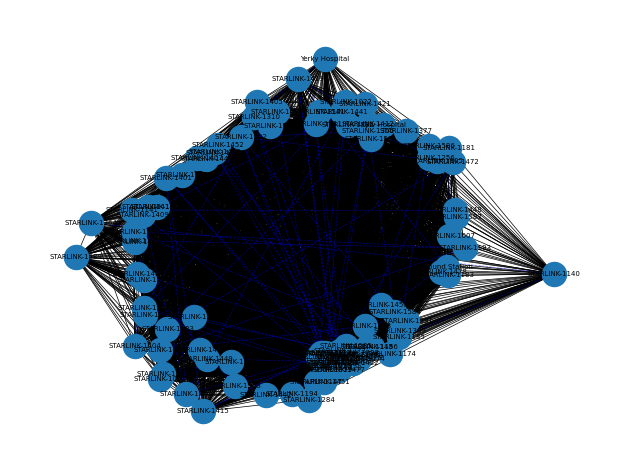

In [ ]:
sim.visualize()

In [ ]:
# simulate constellation packet flow for 10 packets
sim.runSimulation(10)

['STARLINK-1007', 'STARLINK-1008', 'STARLINK-1009', 'STARLINK-1010', 'STARLINK-1011', 'STARLINK-1140', 'STARLINK-1141', 'STARLINK-1148', 'STARLINK-1155', 'STARLINK-1156', 'STARLINK-1310', 'STARLINK-1319', 'STARLINK-1305', 'STARLINK-1304', 'STARLINK-1302', 'STARLINK-1019', 'STARLINK-1020', 'STARLINK-1021', 'STARLINK-1022', 'STARLINK-1024', 'STARLINK-1181', 'STARLINK-1185', 'STARLINK-1183', 'STARLINK-1147', 'STARLINK-1193', 'STARLINK-1194', 'STARLINK-1174', 'STARLINK-1180', 'STARLINK-1177', 'STARLINK-1149', 'STARLINK-1256', 'STARLINK-1291', 'STARLINK-1284', 'STARLINK-1263', 'STARLINK-1272', 'STARLINK-1372', 'STARLINK-1377', 'STARLINK-1309', 'STARLINK-1338', 'STARLINK-1376', 'STARLINK-1340', 'STARLINK-1343', 'STARLINK-1347', 'STARLINK-1349', 'STARLINK-1360', 'STARLINK-1364', 'STARLINK-1365', 'STARLINK-1441', 'STARLINK-1442', 'STARLINK-1443', 'STARLINK-1401', 'STARLINK-1402', 'STARLINK-1404', 'STARLINK-1408', 'STARLINK-1413', 'STARLINK-1420', 'STARLINK-1422', 'STARLINK-1351', 'STARLINK-137